In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

# **GTSRB**

German Traffic Sign Recognition Benchmark: In this notebook, I'll train an image classification model using PyTorch. 

For this task I chose the GTSRB dataset provided by the torchvision lybrary.

https://pytorch.org/vision/stable/generated/torchvision.datasets.GTSRB.html#torchvision.datasets.GTSRB

## **Step 1: Exploratory Data Analysis**

TODO:
* Look up the classes
* Plot the distribution
* Fix eventual problems with the data

### **Downloading data** 

In [37]:
transforms = transforms.Compose([
        transforms.Resize([120,120]), # the image are not all equal in size, we need to define a standard size
        transforms.ToTensor() # converts images to torch Tensors and rescales pixels to [0;1] 
    ])

train_dataset = torchvision.datasets.GTSRB(
    root='.',
    split='train',
    transform=transforms,
    download=True
)

test_dataset = torchvision.datasets.GTSRB(
    root='.',
    split='test',
    transform=transforms,
    download=True
)

In [38]:
len(train_dataset)

26640

### **Data Loader**

In [39]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

### **Visualization**

Image shape: torch.Size([128, 3, 120, 120]), label shape: torch.Size([128])
Min and max pixel values: [0.0, 1.0]
Number of classes 42


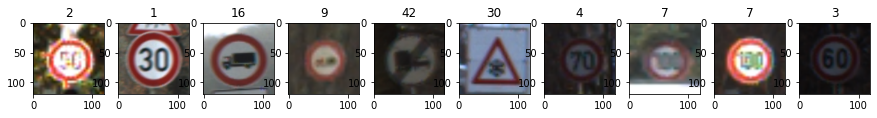

In [40]:
for x, y in train_loader:
    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')
    figure, axis = plt.subplots(1, 10, figsize=(15,15))
    for idx in range(10):
        axis[idx].imshow(x[idx].permute(1, 2, 0))
        axis[idx].set_title(y[idx].numpy())
    break

We can see from this first plot that the images are labeled with numbers from 0 to 42, meaning there 43 classes. If the performances are not sufficient, we could try to reduce the number of classes by grouping similar traffic signs together (speed limit, change of direction, ...)

Another thing to see is that images vary largely in contrast, sharpness and quality, it might not be useful to try to augment the data as the difference between images is already really high.

<img src='https://miro.medium.com/max/1100/1*mWK70K4agwvlwR-JBiT-aw.webp' style="background-color:white" width="600" height="500" />

# **Step 2: Modeling**

TODO:
* Define a model architecture
* Define a loss and an optimizer

In order to perform an image classification task, it is common to use a Convolutional Neural Network (CNN) as this type of architecture has various benefits.
To name a few:
* The creation of feature maps with convolutions allows to reduce significantly the number of parameters needed (compared to one pixel = one input neuron)
* The model can detect patterns in different part of the image, even if rotated

In order to train a CNN with PyTorch, we have to be aware of the image size at all steps. Indeed, we need to define the input dimension of the first dense layer,  which is the dimension of the flattened image after the convolutions multiplied by the number of feature maps.
Output size of convolution and pooling layers :

*   W = input shape
*   F = kernel size
*   P = padding
*   S = Stride
*   D = dilation (always 1 here)

Convolution: $W_{out} = \left \lfloor \frac{W - F + 2P}{S} \right \rfloor +1$

Max pooling: $W_{out} = \left \lfloor \frac{W +2*P - D * (F -1) -1}{S} +1 \right \rfloor$

In [45]:
def conv_arithmetic(input_size:list, kernel_size:list, padding:list, stride:list, type:str):
  """ 
  For type 'conv':
    Returns the output shape of an image after one iteration of "Zero padding, non-unit strides" convolution
    reference: https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html
  For type 'max_pooling':
    Returns the output shape of an image after one ieration of max pooling (2d)
    reference: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
  """
  assert type in ['conv', 'max_pooling'], "invalid type"
  
  if type == 'conv':
      return np.floor(np.divide(input_size + 2*padding[0] - kernel_size[0], stride[0])) + 1
  elif type == 'max_pooling':
      return np.floor(np.divide(input_size +2*padding[1] -1*(kernel_size[1]-1) -1, stride[1]) +1)


def compute_shapes(img_size:int, seq:list):
  for it in range(len(seq)):
    img_size = conv_arithmetic(img_size, kernel_size=[3,2], padding=[1,0], stride=[2,2], type=seq[it])
    print(f'  {it}: {seq[it]} => image size: {img_size}')
  return img_size

In [46]:
print('AlexNet inspired model:')
compute_shapes(img_size=120, seq=['conv','max_pooling','conv','max_pooling','conv'])

AlexNet inspired model:
  0: conv => image size: 60.0
  1: max_pooling => image size: 30.0
  2: conv => image size: 15.0
  3: max_pooling => image size: 7.0
  4: conv => image size: 4.0


4.0

As a first architecture, I chose to create a smaller copy of the AlexNet architecture, combining convolutions and max pooling sequentially. 

The previous functions will help us calculate the dimensions of the output image after the Convolution part of the network (PyTorch requires an input dimension for the Linear layers).

Therefore the input shape of the Dense part of the net shall be _**feature_map_dimension * 4 * 4**_, with the feature map dimension being the output dimension of the final convolution.

In [47]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()

        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.Dense = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(256*4*4, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),

            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            nn.Linear(512, K)
        )

    def forward(self, x):
        x = self.convolutions(x)
        flat = x.view(x.shape[0], -1)
        x = self.Dense(flat)
        return x

Now we instantiate the model and define the loss function and optimizer.
* The cross entropy loss is appropriate for a classification problem 
* Adam is a standard choice for an optimize

In [48]:
model = CNN(43)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In order to make the computation faster, we move the model to the GPU, we will eventually do the same for each training batch

In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


In [50]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs: int = 10):
    train_losses, test_losses = np.zeros(epochs), np.zeros(epochs)

    for it in range(epochs):  # iterate over epochs

        t0 = datetime.now()
        model.train()
        train_loss = []

        for inputs, targets in train_loader:  # iterate over batches
            inputs, targets = inputs.to(device), targets.to(device)  # convert the targets to the new classes
            optimizer.zero_grad()  # reset the optimizer gradient between steps

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # backward pass
            loss.backward()  # compute the gradient
            optimizer.step()  # perform a step of gradient descent

            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)

        model.eval()  # eval mode modifies the behaviour of certain layers
        # for example: dropout and batch norm are used only in train() mode and not in eval()
        test_loss = []

        for inputs, targets in test_loader:  # iterate over batches
            inputs, targets = inputs.to(
                device), targets.to(device)  # convert the targets to the new classes

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        train_losses[it], test_losses[it] = train_loss,  test_loss
        dt = datetime.now() - t0

        print(
            f'Epoch {it+1} / {epochs}: Train Loss : {train_loss:.4f}, Test Loss : {test_loss:.4f}, duration: {dt}')

    return train_losses, test_losses


In [51]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, 10)

Epoch 1 / 10: Train Loss : 0.9130, Test Loss : 0.3934, duration: 0:00:30.057568
Epoch 2 / 10: Train Loss : 0.1428, Test Loss : 0.2713, duration: 0:00:31.638323
Epoch 3 / 10: Train Loss : 0.0835, Test Loss : 0.2976, duration: 0:00:29.859968
Epoch 4 / 10: Train Loss : 0.0716, Test Loss : 0.2516, duration: 0:00:29.569302
Epoch 5 / 10: Train Loss : 0.0494, Test Loss : 0.2495, duration: 0:00:29.721212
Epoch 6 / 10: Train Loss : 0.0374, Test Loss : 0.2819, duration: 0:00:29.622523
Epoch 7 / 10: Train Loss : 0.0250, Test Loss : 0.2631, duration: 0:00:29.717578
Epoch 8 / 10: Train Loss : 0.0247, Test Loss : 0.2509, duration: 0:00:29.859209
Epoch 9 / 10: Train Loss : 0.0278, Test Loss : 0.2891, duration: 0:00:29.701446
Epoch 10 / 10: Train Loss : 0.0251, Test Loss : 0.2571, duration: 0:00:29.727185


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

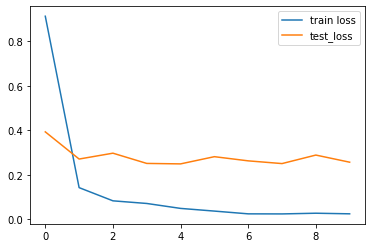

In [52]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.plot

              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82        60
         1.0       0.96      0.94      0.95       720
         2.0       0.93      0.97      0.95       750
         3.0       0.95      0.94      0.94       450
         4.0       0.97      0.96      0.96       660
         5.0       0.79      0.94      0.86       630
         6.0       0.96      0.83      0.89       150
         7.0       0.87      0.87      0.87       450
         8.0       0.93      0.83      0.88       450
         9.0       0.94      0.97      0.96       480
        10.0       0.96      0.97      0.97       660
        11.0       0.87      0.93      0.90       420
        12.0       0.98      0.94      0.96       690
        13.0       0.98      1.00      0.99       720
        14.0       0.96      1.00      0.98       270
        15.0       0.99      1.00      0.99       210
        16.0       1.00      0.89      0.94       150
        17.0       0.98    

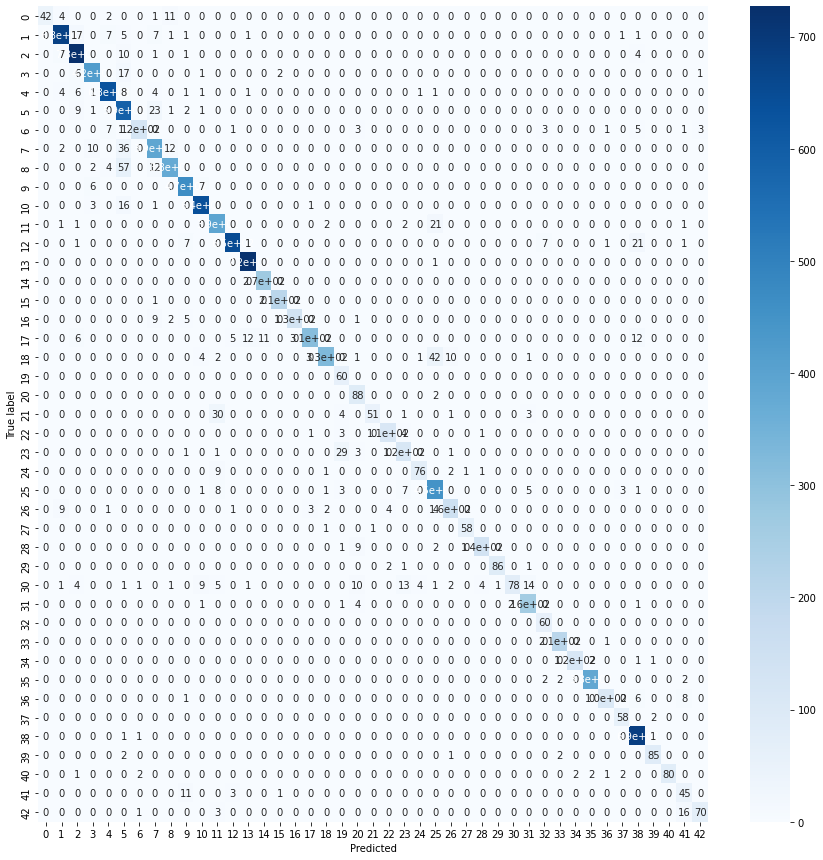

In [53]:
def report(loader):
  p_test, y_test = np.array([]), np.array([])
  X_test = []
  model.eval()

  for inputs, targets in loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    X_test.append(inputs)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    y_test = np.concatenate((y_test, targets.cpu()))

  print(classification_report(y_test, p_test))
  cm = confusion_matrix(y_test, p_test)
  plt.figure(figsize=(15,15))
  sns.heatmap(cm, cmap='Blues', annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True label')
  plt.show()

  return X_test, p_test, y_test

X_test, p_test, y_test = report(loader=test_loader)